`pip install reformer_pytorch`


### References

- Text classification with the torchtext library: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
- reformer-pytorch: https://github.com/lucidrains/reformer-pytorch?tab=readme-ov-file
- IMDB dataset: http://ai.stanford.edu/~amaas/data/sentiment/


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from reformer_pytorch import ReformerLM
from sklearn.metrics import accuracy_score, f1_score
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Build the dataset

Use the IMDB dataset for sentiment analysis. The dataset is already available in the `torchtext` library.

- label = 0 means negative sentiment
- label = 1 means positive sentiment.


In [3]:
# Checkout sample data
train_iter, test_iter = IMDB(split=("train", "test"))

labels = {}
count = 0
for label, line in test_iter:
    # print(label, line)
    if label == 2 and len(line) > 0 and len(line) < 100 and count < 5:
        print(label, line)
        # break
        count += 1
    # labels[label] = labels.get(label, 0) + 1
# labels

2 Brilliant and moving performances by Tom Courtenay and Peter Finch.
2 Add this little gem to your list of holiday regulars. It is<br /><br />sweet, funny, and endearing
2 This is a great movie. Too bad it is not available on home video.
2 This is a good film. This is very funny. Yet after this film there were no good Ernest films!
2 If you like Pauly Shore, you'll love Son in Law. If you hate Pauly Shore, then, well...I liked it!


In [4]:
# Basic tokenizer for English
tokenizer = get_tokenizer("basic_english")


# Build vocabulary
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


# Reload the training iterator for building vocab
train_iter, _ = IMDB(split=("train", "test"))
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(
    vocab["<unk>"]
)  # Set default index for out-of-vocabulary tokens
NUM_TOKENS = len(vocab)

In [5]:
def text_pipeline(x):
    return vocab(tokenizer(x))


def label_pipeline(x):
    # the original dataset
    # 1 for negative, 2 for positive
    return x - 1


class IMDBDataset(Dataset):
    def __init__(self, split):
        self.examples = list()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
        self.avg_length = self.calculate_avg_length()
        # to avoid too long padding
        for label, text in IMDB(split=split):
            tokenized_text = tokenizer(text)
            if len(tokenized_text) <= self.avg_length:
                self.examples.append((label, text))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        label, text = self.examples[idx]
        label = self.label_pipeline(label)
        text = torch.tensor(self.text_pipeline(text), dtype=torch.int64)
        return text, label

    def calculate_avg_length(self):
        lengths = [len(tokenizer(text)) for _, text in IMDB(split="train")]
        return sum(lengths) / len(lengths)


def collate_batch(batch):
    label_list, text_list = [], []
    max_len = 256  # Define the maximum sequence length

    for _text, _label in batch:
        label_list.append(_label)
        # Ensure _text is a tensor
        if len(_text) > max_len:
            # Truncate if longer than max_len
            _text = _text[:max_len]
        elif len(_text) < max_len:
            # Pad if shorter than max_len
            padding_length = max_len - len(_text)
            padding = torch.full(
                (padding_length,), vocab["<pad>"], dtype=torch.int64
            )  # Ensure vocab['<pad>'] is defined and consistent with your data
            _text = torch.cat((_text, padding), dim=0)

        text_list.append(_text)

    # Stack all texts and labels into tensors
    texts = torch.stack(text_list, dim=0)
    labels = torch.tensor(label_list, dtype=torch.int64)

    return texts, labels

In [6]:
# Create DataLoader
train_dataset = IMDBDataset("train")
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch
)
test_dataset = IMDBDataset("test")
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch
)

In [7]:
for text, label in train_loader:
    print("Text batch shape:", text.size())
    # print(text)
    print("Label batch shape:", label.size())
    # print(label)
    break

Text batch shape: torch.Size([32, 256])
Label batch shape: torch.Size([32])


In [8]:
NUM_CLASSES = 2
NUM_ENCODER_LAYERS = 3
NUM_HEADS = 4
EMEBED_DIM = 256
TRAIN_EPOCHS = 6
seq_length = 256

## Transformer


In [9]:
class EncoderOnlyTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_encoder_layers=1, dim_feedforward=256):
        super(EncoderOnlyTransformer, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_encoder_layers,
        )
        self.dropout = nn.Dropout(0.2)
        self.embedding = nn.Embedding(NUM_TOKENS, d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src)
        encoded_output = self.transformer_encoder(src)
        # encoded_output = encoded_output[:, -1, :]
        encoded_output = self.dropout(encoded_output)
        encoded_output = encoded_output.max(dim=1)[0]
        output = self.classifier(encoded_output)
        return output


transformer_model = EncoderOnlyTransformer(
    d_model=EMEBED_DIM,
    nhead=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=EMEBED_DIM,
).to(device)

In [10]:
total_trainable_params = sum(
    p.numel() for p in transformer_model.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.\n")

26,962,689 training parameters.



### Train the Transformer model


In [11]:
# use cross entropy loss for classification task
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.00001)

In [12]:
def calculate_accuracy(output, y_true):
    y_pred = torch.sigmoid(output).round()
    return accuracy_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

In [13]:
# Training Loop
transformer_model.train()
start_time = time.time()
transformer_train_loss = []
transformer_train_acc = []
current_step = 0
for epochs in tqdm.tqdm(range(TRAIN_EPOCHS)):
    for reviews, label in train_loader:
        reviews = reviews.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = transformer_model(reviews)
        output = output.squeeze()
        label = label.float()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if current_step % 10 == 0:
            acc = calculate_accuracy(output, label)
            transformer_train_loss.append(loss.item())
            transformer_train_acc.append(acc)
            if current_step % 100 == 0:
                print(
                    f"""Step {current_step}: Loss {
                        loss.item()} Accuracy {acc}"""
                )
        current_step += 1

elapsed_time = time.time() - start_time
print("Training transformer completed.")
print(f"Training time: {elapsed_time:.2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Step 0: Loss 0.6903313398361206 Accuracy 0.625
Step 100: Loss 0.6711369156837463 Accuracy 0.5625
Step 200: Loss 0.6750435829162598 Accuracy 0.5625
Step 300: Loss 0.677862286567688 Accuracy 0.53125
Step 400: Loss 0.6641033887863159 Accuracy 0.59375
Step 500: Loss 0.6569305658340454 Accuracy 0.625


 17%|█▋        | 1/6 [00:46<03:53, 46.65s/it]

Step 600: Loss 0.65130615234375 Accuracy 0.5625
Step 700: Loss 0.7105265259742737 Accuracy 0.5625
Step 800: Loss 0.6322641372680664 Accuracy 0.6875
Step 900: Loss 0.5881092548370361 Accuracy 0.78125
Step 1000: Loss 0.5980153679847717 Accuracy 0.71875


 33%|███▎      | 2/6 [01:32<03:03, 45.98s/it]

Step 1100: Loss 0.5761356353759766 Accuracy 0.8125
Step 1200: Loss 0.5496800541877747 Accuracy 0.84375
Step 1300: Loss 0.6044672727584839 Accuracy 0.6875
Step 1400: Loss 0.6501498222351074 Accuracy 0.53125
Step 1500: Loss 0.5692673921585083 Accuracy 0.71875


 50%|█████     | 3/6 [02:17<02:17, 45.84s/it]

Step 1600: Loss 0.5444921851158142 Accuracy 0.71875
Step 1700: Loss 0.4902651607990265 Accuracy 0.8125
Step 1800: Loss 0.5018073916435242 Accuracy 0.84375
Step 1900: Loss 0.6005122661590576 Accuracy 0.65625
Step 2000: Loss 0.5417637825012207 Accuracy 0.71875


 67%|██████▋   | 4/6 [03:03<01:31, 45.76s/it]

Step 2100: Loss 0.5609153509140015 Accuracy 0.75
Step 2200: Loss 0.506327748298645 Accuracy 0.6875
Step 2300: Loss 0.4931066036224365 Accuracy 0.78125
Step 2400: Loss 0.5553968548774719 Accuracy 0.6875
Step 2500: Loss 0.514446496963501 Accuracy 0.78125


 83%|████████▎ | 5/6 [03:49<00:45, 45.76s/it]

Step 2600: Loss 0.4866301417350769 Accuracy 0.8125
Step 2700: Loss 0.5388359427452087 Accuracy 0.6875
Step 2800: Loss 0.5656405091285706 Accuracy 0.78125
Step 2900: Loss 0.47753971815109253 Accuracy 0.8125
Step 3000: Loss 0.5385168790817261 Accuracy 0.71875
Step 3100: Loss 0.49306946992874146 Accuracy 0.6875


100%|██████████| 6/6 [04:35<00:00, 45.93s/it]

Training transformer completed.
Training time: 275.62 seconds


### Evaluate the Transformer model


In [14]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode

    true_labels = []
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for texts, labels in dataloader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            outputs = outputs.squeeze()

            probs = torch.sigmoid(outputs)
            predicted_labels = probs.round()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted_labels.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="binary")

    return accuracy, f1

In [15]:
transformer_accuracy, transformer_f1 = evaluate_model(
    model=transformer_model, dataloader=test_loader, device=device
)

In [16]:
transformer_accuracy, transformer_f1

(0.7868349651999528, 0.7929888876159926)

In [17]:
# Save the model
model_path = "transformer_model_weights.pth"
torch.save(transformer_model.state_dict(), model_path)

In [18]:
import gc

# Clean up the memory
del transformer_model
# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
gc.collect()  # Explicit garbage collection

0

In [28]:
transformer = EncoderOnlyTransformer()
transformer.load_state_dict(torch.load(model_path))
transformer.eval()

RuntimeError: Error(s) in loading state_dict for EncoderOnlyTransformer:
	Missing key(s) in state_dict: "transformer_encoder.layers.0.self_attn.in_proj_weight", "transformer_encoder.layers.0.self_attn.in_proj_bias", "transformer_encoder.layers.0.self_attn.out_proj.weight", "transformer_encoder.layers.0.self_attn.out_proj.bias", "transformer_encoder.layers.0.linear1.weight", "transformer_encoder.layers.0.linear1.bias", "transformer_encoder.layers.0.linear2.weight", "transformer_encoder.layers.0.linear2.bias", "transformer_encoder.layers.0.norm1.weight", "transformer_encoder.layers.0.norm1.bias", "transformer_encoder.layers.0.norm2.weight", "transformer_encoder.layers.0.norm2.bias", "embedding.weight". 
	Unexpected key(s) in state_dict: "encoder.token_emb.weight", "encoder.pos_emb.inv_freq", "encoder.reformer.layers.blocks.0.f.net.norm.weight", "encoder.reformer.layers.blocks.0.f.net.norm.bias", "encoder.reformer.layers.blocks.0.f.net.fn.toqk.weight", "encoder.reformer.layers.blocks.0.f.net.fn.tov.weight", "encoder.reformer.layers.blocks.0.f.net.fn.to_out.weight", "encoder.reformer.layers.blocks.0.f.net.fn.to_out.bias", "encoder.reformer.layers.blocks.0.g.net.norm.weight", "encoder.reformer.layers.blocks.0.g.net.norm.bias", "encoder.reformer.layers.blocks.0.g.net.fn.fn.w1.weight", "encoder.reformer.layers.blocks.0.g.net.fn.fn.w1.bias", "encoder.reformer.layers.blocks.0.g.net.fn.fn.w2.weight", "encoder.reformer.layers.blocks.0.g.net.fn.fn.w2.bias", "encoder.reformer.layers.blocks.1.f.net.norm.weight", "encoder.reformer.layers.blocks.1.f.net.norm.bias", "encoder.reformer.layers.blocks.1.f.net.fn.toqk.weight", "encoder.reformer.layers.blocks.1.f.net.fn.tov.weight", "encoder.reformer.layers.blocks.1.f.net.fn.to_out.weight", "encoder.reformer.layers.blocks.1.f.net.fn.to_out.bias", "encoder.reformer.layers.blocks.1.g.net.norm.weight", "encoder.reformer.layers.blocks.1.g.net.norm.bias", "encoder.reformer.layers.blocks.1.g.net.fn.fn.w1.weight", "encoder.reformer.layers.blocks.1.g.net.fn.fn.w1.bias", "encoder.reformer.layers.blocks.1.g.net.fn.fn.w2.weight", "encoder.reformer.layers.blocks.1.g.net.fn.fn.w2.bias", "encoder.reformer.layers.blocks.2.f.net.norm.weight", "encoder.reformer.layers.blocks.2.f.net.norm.bias", "encoder.reformer.layers.blocks.2.f.net.fn.toqk.weight", "encoder.reformer.layers.blocks.2.f.net.fn.tov.weight", "encoder.reformer.layers.blocks.2.f.net.fn.to_out.weight", "encoder.reformer.layers.blocks.2.f.net.fn.to_out.bias", "encoder.reformer.layers.blocks.2.g.net.norm.weight", "encoder.reformer.layers.blocks.2.g.net.norm.bias", "encoder.reformer.layers.blocks.2.g.net.fn.fn.w1.weight", "encoder.reformer.layers.blocks.2.g.net.fn.fn.w1.bias", "encoder.reformer.layers.blocks.2.g.net.fn.fn.w2.weight", "encoder.reformer.layers.blocks.2.g.net.fn.fn.w2.bias", "encoder.reformer.layers.irrev_blocks.0.f.norm.weight", "encoder.reformer.layers.irrev_blocks.0.f.norm.bias", "encoder.reformer.layers.irrev_blocks.0.f.fn.toqk.weight", "encoder.reformer.layers.irrev_blocks.0.f.fn.tov.weight", "encoder.reformer.layers.irrev_blocks.0.f.fn.to_out.weight", "encoder.reformer.layers.irrev_blocks.0.f.fn.to_out.bias", "encoder.reformer.layers.irrev_blocks.0.g.norm.weight", "encoder.reformer.layers.irrev_blocks.0.g.norm.bias", "encoder.reformer.layers.irrev_blocks.0.g.fn.fn.w1.weight", "encoder.reformer.layers.irrev_blocks.0.g.fn.fn.w1.bias", "encoder.reformer.layers.irrev_blocks.0.g.fn.fn.w2.weight", "encoder.reformer.layers.irrev_blocks.0.g.fn.fn.w2.bias", "encoder.reformer.layers.irrev_blocks.1.f.norm.weight", "encoder.reformer.layers.irrev_blocks.1.f.norm.bias", "encoder.reformer.layers.irrev_blocks.1.f.fn.toqk.weight", "encoder.reformer.layers.irrev_blocks.1.f.fn.tov.weight", "encoder.reformer.layers.irrev_blocks.1.f.fn.to_out.weight", "encoder.reformer.layers.irrev_blocks.1.f.fn.to_out.bias", "encoder.reformer.layers.irrev_blocks.1.g.norm.weight", "encoder.reformer.layers.irrev_blocks.1.g.norm.bias", "encoder.reformer.layers.irrev_blocks.1.g.fn.fn.w1.weight", "encoder.reformer.layers.irrev_blocks.1.g.fn.fn.w1.bias", "encoder.reformer.layers.irrev_blocks.1.g.fn.fn.w2.weight", "encoder.reformer.layers.irrev_blocks.1.g.fn.fn.w2.bias", "encoder.reformer.layers.irrev_blocks.2.f.norm.weight", "encoder.reformer.layers.irrev_blocks.2.f.norm.bias", "encoder.reformer.layers.irrev_blocks.2.f.fn.toqk.weight", "encoder.reformer.layers.irrev_blocks.2.f.fn.tov.weight", "encoder.reformer.layers.irrev_blocks.2.f.fn.to_out.weight", "encoder.reformer.layers.irrev_blocks.2.f.fn.to_out.bias", "encoder.reformer.layers.irrev_blocks.2.g.norm.weight", "encoder.reformer.layers.irrev_blocks.2.g.norm.bias", "encoder.reformer.layers.irrev_blocks.2.g.fn.fn.w1.weight", "encoder.reformer.layers.irrev_blocks.2.g.fn.fn.w1.bias", "encoder.reformer.layers.irrev_blocks.2.g.fn.fn.w2.weight", "encoder.reformer.layers.irrev_blocks.2.g.fn.fn.w2.bias", "encoder.norm.weight", "encoder.norm.bias". 

## Build the Reformer


In [19]:
class ReformerForClassification(nn.Module):
    def __init__(self, num_tokens, emb_dim, dim, depth, heads, max_seq_len):
        super(ReformerForClassification, self).__init__()
        self.encoder = ReformerLM(
            num_tokens=num_tokens,
            emb_dim=emb_dim,
            dim=dim,
            depth=depth,
            heads=heads,
            max_seq_len=max_seq_len,
            fixed_position_emb=True,
            return_embeddings=True,
        )

        # Classification head
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(dim, 1)

    def forward(self, x):
        # Encoder processes the input
        encoded_output = self.encoder(x)
        encoded_output = self.dropout(encoded_output)
        encoded_output = encoded_output.max(dim=1)[0]
        output = self.classifier(encoded_output)

        return output

### Train the Reformer model


In [20]:
reformer = ReformerForClassification(
    num_tokens=NUM_TOKENS,
    emb_dim=EMEBED_DIM,
    dim=EMEBED_DIM,
    depth=NUM_ENCODER_LAYERS,
    heads=NUM_HEADS,
    max_seq_len=seq_length,
).to(device)

In [21]:
total_trainable_params = sum(
    p.numel() for p in reformer.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.\n")

27,946,241 training parameters.



In [22]:
optimizer = optim.Adam(reformer.parameters(), lr=0.00001)
reformer_train_loss = []
reformer_train_acc = []
# for current_step in tqdm.tqdm(range(total_steps)):
current_step = 0
start_time = time.time()
for epochs in tqdm.tqdm(range(TRAIN_EPOCHS)):
    for reviews, label in train_loader:
        reviews = reviews.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = reformer(reviews)
        output = output.squeeze()
        # print(output.size(), label.size())
        label = label.float()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        current_step += 1
        if current_step % 10 == 0:
            acc = calculate_accuracy(output, label)
            reformer_train_loss.append(loss.item())
            reformer_train_loss.append(acc)
            if current_step % 100 == 0:
                print(
                    f"""Step {current_step}: Loss {
                        loss.item()} Accuracy {acc}"""
                )

elapsed_time = time.time() - start_time
print("Training Reformer completed.")
print(f"Training time: {elapsed_time:.2f} seconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Step 100: Loss 0.6915448307991028 Accuracy 0.5625
Step 200: Loss 0.6908938884735107 Accuracy 0.5
Step 300: Loss 0.6910299062728882 Accuracy 0.5
Step 400: Loss 0.7083938121795654 Accuracy 0.375
Step 500: Loss 0.6128970384597778 Accuracy 0.75


 17%|█▋        | 1/6 [04:42<23:33, 282.69s/it]

Step 600: Loss 0.6875300407409668 Accuracy 0.46875
Step 700: Loss 0.6411499977111816 Accuracy 0.65625
Step 800: Loss 0.6354114413261414 Accuracy 0.6875
Step 900: Loss 0.6034781336784363 Accuracy 0.75
Step 1000: Loss 0.6309852004051208 Accuracy 0.625


 33%|███▎      | 2/6 [09:26<18:54, 283.51s/it]

Step 1100: Loss 0.6261836886405945 Accuracy 0.71875
Step 1200: Loss 0.6302128434181213 Accuracy 0.625
Step 1300: Loss 0.6307201385498047 Accuracy 0.6875
Step 1400: Loss 0.6752927303314209 Accuracy 0.5625
Step 1500: Loss 0.6355257034301758 Accuracy 0.625


 50%|█████     | 3/6 [14:10<14:10, 283.41s/it]

Step 1600: Loss 0.5400670766830444 Accuracy 0.8125
Step 1700: Loss 0.553629457950592 Accuracy 0.78125
Step 1800: Loss 0.6235929727554321 Accuracy 0.75
Step 1900: Loss 0.5749286413192749 Accuracy 0.6875
Step 2000: Loss 0.5631066560745239 Accuracy 0.75


 67%|██████▋   | 4/6 [18:52<09:25, 282.85s/it]

Step 2100: Loss 0.6084562540054321 Accuracy 0.625
Step 2200: Loss 0.5805224776268005 Accuracy 0.75
Step 2300: Loss 0.5794855356216431 Accuracy 0.75
Step 2400: Loss 0.49851083755493164 Accuracy 0.875
Step 2500: Loss 0.47883057594299316 Accuracy 0.9375


 83%|████████▎ | 5/6 [23:33<04:42, 282.46s/it]

Step 2600: Loss 0.432800829410553 Accuracy 1.0
Step 2700: Loss 0.5317515134811401 Accuracy 0.84375
Step 2800: Loss 0.4673944413661957 Accuracy 0.84375
Step 2900: Loss 0.5047050714492798 Accuracy 0.8125
Step 3000: Loss 0.49843573570251465 Accuracy 0.75
Step 3100: Loss 0.4497326612472534 Accuracy 0.84375


100%|██████████| 6/6 [28:19<00:00, 283.27s/it]

Training Reformer completed.
Training time: 1699.65 seconds


### Evaluate the Reformer model


In [23]:
reformer_accuracy, reformer_f1 = evaluate_model(
    model=reformer, dataloader=test_loader, device=device
)

In [24]:
reformer_accuracy, reformer_f1

(0.770909519877315, 0.775776469229881)

In [25]:
# Save the model
model_path = "reformer_model_weights.pth"
torch.save(reformer.state_dict(), model_path)

## Plot the results


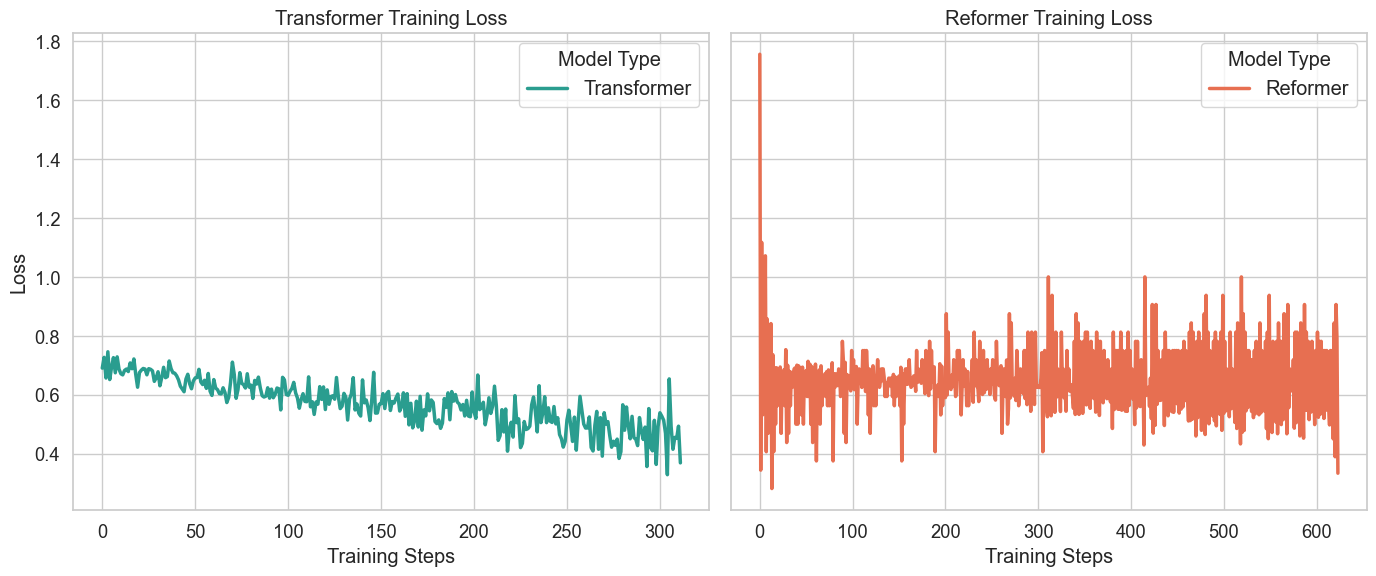

In [27]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
colors = ["#2a9d8f", "#e76f51"]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plotting for Transformer
sns.lineplot(
    ax=axes[0],
    x=np.arange(len(transformer_train_loss)),
    y=transformer_train_loss,
    label="Transformer",
    linewidth=2.5,
    color=colors[0],
)
axes[0].set_title("Transformer Training Loss")
axes[0].set_xlabel("Training Steps")
axes[0].set_ylabel("Loss")

# Plotting for Reformer
sns.lineplot(
    ax=axes[1],
    x=np.arange(len(reformer_train_loss)),
    y=reformer_train_loss,
    label="Reformer",
    linewidth=2.5,
    color=colors[1],
)
axes[1].set_title("Reformer Training Loss")
axes[1].set_xlabel("Training Steps")
axes[1].set_ylabel("Loss")

axes[0].legend(frameon=True, fontsize="medium", loc="upper right", title="Model Type")
axes[1].legend(frameon=True, fontsize="medium", loc="upper right", title="Model Type")

plt.tight_layout()
plt.savefig("training_loss_comparison.png", format="png", dpi=300)
plt.show()